In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline

from IPython.display import display, Latex, clear_output
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import S
from pynrc.obs_nircam import model_to_hdulist
pynrc.setup_logging('WARNING', verbose=False)

In [3]:
fov_pix = 65
oversample = 2

psf_info={'fov_pix':fov_pix, 'oversample':oversample,
          'save':False, 'force':True, 'jitter':None}


In [4]:
cf_ote = nrc_utils.psf_coeff('F444W', **psf_info)
psf_ote, psf_ote_over = nrc_utils.gen_image_coeff('F444W', coeff=cf_ote, 
                                                  fov_pix=fov_pix, oversample=oversample, 
                                                  return_oversample=True)

In [5]:
cf_off = nrc_utils.psf_coeff('F444W', 'CIRCLYOT', **psf_info)
psf_off, psf_off_over = nrc_utils.gen_image_coeff('F444W', 'CIRCLYOT', coeff=cf_off, 
                                                  fov_pix=fov_pix, oversample=oversample, 
                                                  return_oversample=True)

In [6]:
cf_cen = nrc_utils.psf_coeff('F444W', pupil='CIRCLYOT', mask='MASK335R', **psf_info)
psf_cen, psf_cen_over = nrc_utils.gen_image_coeff('F444W', 'CIRCLYOT', 'MASK335R', coeff=cf_cen, 
                                                  fov_pix=fov_pix, oversample=oversample, 
                                                  return_oversample=True)

In [11]:
fov_asec = fov_pix*nrc_utils.pixscale_LW
pixscale = nrc_utils.pixscale_LW / oversample

In [76]:
shift_array = np.arange(0,63,3)
shift_asec = shift_array * pixscale

In [77]:
def mshift(mask, shift_array):
    
    masks = []
    for shift in shift_array:
        mask_shift = nrc_utils.fshift(mask, delx=shift)
        mask_cut = nrc_utils.pad_or_cut_to_size(mask_shift, psf_ote_over.shape)
        masks.append(mask_cut)
    return masks

In [78]:
mask = nrc_utils.coron_trans('MASK335R', fov=2*fov_asec, pixscale=pixscale)
masks = mshift(mask, shift_array)

In [79]:
shift_array

array([ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48,
       51, 54, 57, 60])

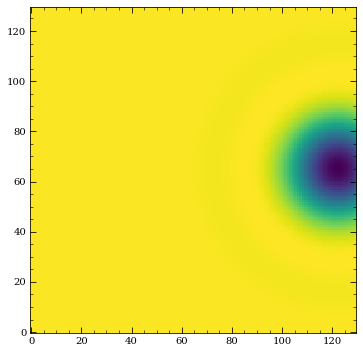

In [80]:
plt.imshow(masks[-2])

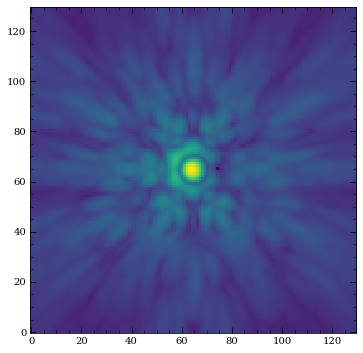

In [86]:
plt.imshow((psf_ote_over*masks[3])**0.2)

In [91]:
psf_list = []
psf_over_list = []
for i, offset in enumerate(shift_asec):
    print(shift_array[i])
    nrc = pynrc.NIRCam('F444W', pupil='CIRCLYOT', mask='MASK335R',
                       offset_r=offset, offset_theta=-90, 
                       fov_pix=2*fov_pix+1, oversample=2,
                       force=True, save=False)
    psf0, psf1 = nrc.gen_psf(return_oversample=True)
    psf_list.append(psf0)
    psf_over_list.append(psf1)

0
3
6
9
12
15
18
21
24
27
30
33
36
39
42
45
48
51
54
57
60


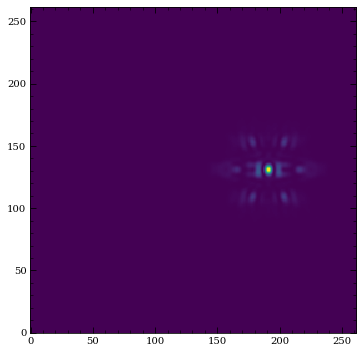

In [92]:
plt.imshow(psf_over_list[-1])

In [93]:
for i, psf in enumerate(psf_over_list):
    psf_list[i] = nrc_utils.fshift(psf_list[i], delx=-shift_array[i]/2)
    psf_over_list[i] = nrc_utils.fshift(psf_over_list[i], delx=-shift_array[i]*oversample/2)

In [94]:
masks[0].shape

(130, 130)

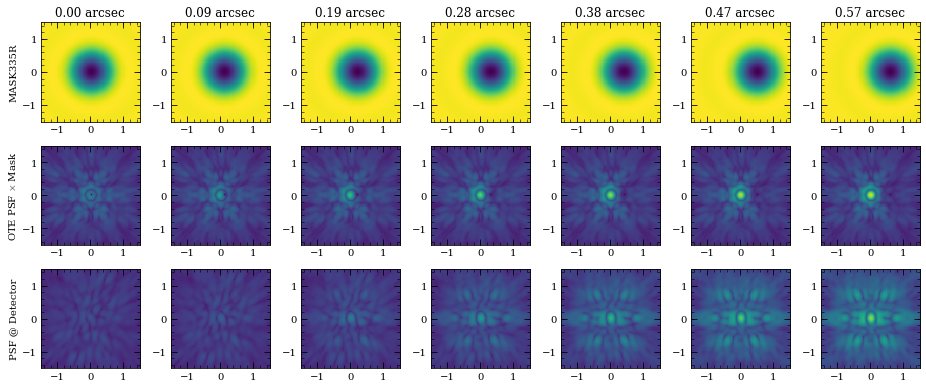

In [141]:
fig, axes = plt.subplots(3, 7, figsize=(13,5.5))

extent = np.array([-1,1,-1,1])*pixscale*masks[0].shape[0]/2
xylim = [-1.5,1.5]
for i, ax in enumerate(axes[0]):
    ax.imshow(masks[i], extent=extent)
    ax.set_xlim(xylim)
    ax.set_ylim(xylim)
    if i==0: ax.set_ylabel('MASK335R')
    ax.set_title('{:.2f} arcsec'.format(shift_asec[i]))

extent = np.array([-1,1,-1,1])*pixscale*psf_ote_over.shape[0]/2
for i, ax in enumerate(axes[1]):
    ax.imshow((masks[i]*psf_ote_over)**0.2, extent=extent, vmin=0, vmax=psf_ote_over.max()**0.2)
    ax.set_xlim(xylim)
    ax.set_ylim(xylim)
    if i==0: ax.set_ylabel(r'OTE PSF $\times$ Mask ')

extent = np.array([-1,1,-1,1])*pixscale*psf_over_list[0].shape[0]/2
for i, ax in enumerate(axes[2]):
    ax.imshow((psf_over_list[i]**0.2), extent=extent, vmin=0, vmax=psf_off_over.max()**0.2)
    ax.set_xlim(xylim)
    ax.set_ylim(xylim)
    if i==0: ax.set_ylabel('PSF @ Detector')

fig.tight_layout()

outdir = '/Users/Jarron/Desktop/JWST-PP/'
fig.savefig(outdir+'M335R_PSF_offset.pdf')

In [96]:
from pynrc.maths.image_manip import align_LSQ, fourier_imshift, fshift

In [97]:
im_sci = nrc_utils.pad_or_cut_to_size(psf_over_list[-1], psf_off_over.shape)
im_ref = psf_off_over
test = align_LSQ(im_ref, im_sci, pad=True)

In [98]:
test

array([  4.05450555e-03,   9.37175434e-04,   9.87082107e-01])

In [99]:
diff = im_sci - im_ref * test[2] #fshift(im_ref, test[0], test[1])*test[2]
diff.max()

4.0559963626371042e-06

In [100]:
np.abs(diff).max()

4.17308481510637e-06

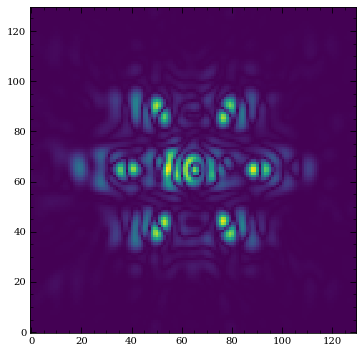

In [101]:
plt.imshow(np.abs(diff)) 

In [117]:
nx = mask.shape[0]
xv = (np.arange(nx)-nx/2)
np.interp(shift_array[5], xv, mask[nx//2,:]**2)

0.22304688707666642

In [206]:
from scipy.optimize import leastsq, least_squares
def f(x, a, b):
    return a*x[0] + b*x[1]

def residual(p, x, y):
    return (y - f(x, *p)).ravel()



nx = mask.shape[0]
xv = (np.arange(nx)-nx/2)

xdata = np.array([psf_off_over, psf_cen_over])

avals = []
bvals = []
for i, psf in enumerate(psf_over_list):
    print(shift_array[i])
    #ydata = fshift(psf, -0.00957687, -0.01525233)
    ydata = nrc_utils.pad_or_cut_to_size(psf, psf_off_over.shape)

    res_best = [0,0]
    chi_fin = 1e10
    a0 = np.interp(shift_array[i], xv, mask[nx//2,:]**2)
    b0 = 1-a0

    for a0 in np.linspace(0,1,10):
        b0 = 1-a0

        res = least_squares(residual, [a0,b0], args=(xdata, ydata), diff_step=0.1, 
                            loss='soft_l1', f_scale=1.0, bounds=([0,0],[1,1]))
        chi_new = np.sum((ydata - f(xdata, *res.x))**2)
        if chi_new < chi_fin:
            chi_fin = chi_new
            res_best = res.x

    ymod = f(xdata, *res_best)
    diff = ydata - ymod
    diff_rebin = nrc_utils.frebin(ydata, scale=1/oversample) - nrc_utils.frebin(ymod, scale=1/oversample)
    print(np.abs(diff_rebin**2).sum(), np.abs(diff_rebin).max())
                
    avals.append(res_best[0])
    bvals.append(res_best[1])

0
1.77730147447e-19 6.3012738015e-11
3
5.2092087392e-11 1.15475912384e-06
6
5.21288311085e-10 3.91128933262e-06
9
2.18798539781e-09 8.21109301441e-06
12
5.72252537349e-09 1.46094677276e-05
15
1.0723654402e-08 2.0485772258e-05
18
1.53615630876e-08 2.36483553401e-05
21
1.79420230713e-08 2.34661763308e-05
24
1.86509356405e-08 2.35650071099e-05
27
1.89869304433e-08 2.3879556925e-05
30
1.97643640823e-08 2.21638913778e-05
33
2.04019640323e-08 1.99714323484e-05
36
2.01653975365e-08 1.89504870105e-05
39
2.1872852386e-08 3.64269194918e-05
42
1.81666366138e-08 2.10256350565e-05
45
1.77326142153e-08 2.33174917979e-05
48
1.76555152474e-08 2.49579603454e-05
51
1.7377915363e-08 2.48529993902e-05
54
1.63955825628e-08 2.2923376783e-05
57
1.49333727727e-08 1.9986709408e-05
60
1.33507608531e-08 1.60155703086e-05


In [207]:
print(avals)


print(bvals)

[1e-10, 0.0014600851547953647, 0.011186138994112889, 0.042293894373131469, 0.10784363815004784, 0.21465918827078478, 0.35727758880702498, 0.51881002896020212, 0.67719918644261512, 0.81260026248291306, 0.91209834608588203, 0.97303930584274922, 0.99999999989999999, 0.99999999989999999, 0.99747836785463517, 0.98637919200464097, 0.97744658619564218, 0.97395660817109719, 0.97557037500743116, 0.98106112357513897, 0.98700435593310476]
[0.99999999989999999, 0.99999999989995336, 0.99999999990374577, 0.99999999992842392, 0.9999999999140553, 0.9031090442019678, 0.70123581472684893, 0.42816422733539594, 0.21667802616463389, 8.486105027716884e-11, 8.2891466671552361e-11, 3.7033118751291105e-11, 1e-10, 1e-10, 5.9040348089546726e-11, 8.6552479723877868e-11, 1.7336458411937986e-11, 2.1599339728671009e-11, 2.0776015306935446e-11, 9.0362780976498747e-11, 8.9488168578999799e-11]


In [238]:
rho = nrc_utils.dist_image(mask, pixscale)
binsize = pixscale
rad_bins = np.arange(rho.min(), rho.max()+binsize, binsize)
rad_mn = nrc_utils.binned_statistic(rho, mask, np.mean, rad_bins)

print(rho.min())

0.707106781187


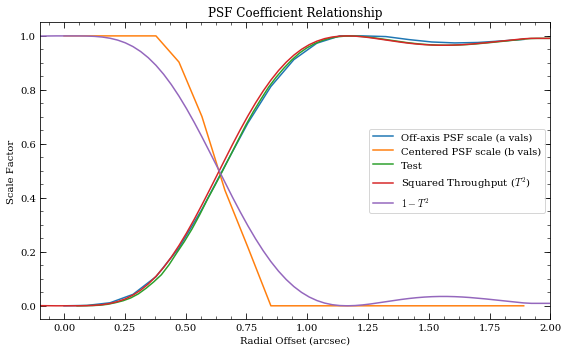

In [235]:
fig,ax = plt.subplots(1,1, figsize=(8,5))

ax.plot(shift_asec, avals, label=r'Off-axis PSF scale (a vals)')
ax.plot(shift_asec, bvals, label=r'Centered PSF scale (b vals)')

ax.plot(rad_bins[1:], rad_mn**2, label='Test')

nx = mask.shape[0]
xv = (np.arange(nx)-nx/2)*pixscale
ax.plot(xv, mask[nx//2,:]**2, label=r'Squared Throughput ($T^2$)')
ax.plot(xv, 1-mask[nx//2,:]**2, label=r'$1-T^2$')

ax.set_xlim([-0.1,2])
ax.set_xlabel('Radial Offset (arcsec)')
ax.set_ylabel('Scale Factor')
ax.set_title('PSF Coefficient Relationship')



ax.legend()

fig.tight_layout()
#fig.savefig(outdir+'psf_coeff_relation.pdf')

In [ ]:
np.interp()

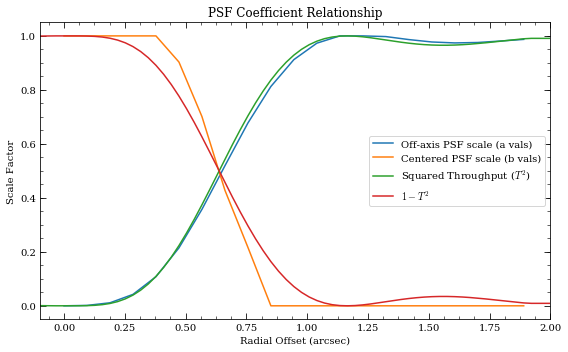

In [208]:
fig,ax = plt.subplots(1,1, figsize=(8,5))

ax.plot(shift_asec, avals, label=r'Off-axis PSF scale (a vals)')
ax.plot(shift_asec, bvals, label=r'Centered PSF scale (b vals)')

nx = mask.shape[0]
xv = (np.arange(nx)-nx/2)*pixscale
ax.plot(xv, mask[nx//2,:]**2, label=r'Squared Throughput ($T^2$)')
ax.plot(xv, 1-mask[nx//2,:]**2, label=r'$1-T^2$')

ax.set_xlim([-0.1,2])
ax.set_xlabel('Radial Offset (arcsec)')
ax.set_ylabel('Scale Factor')
ax.set_title('PSF Coefficient Relationship')

ax.legend()

fig.tight_layout()
fig.savefig(outdir+'psf_coeff_relation.pdf')

In [112]:
shift_asec[13]

1.2284999999999999

In [114]:
avals

[1e-10,
 0.001460085154795028,
 0.011186138994061019,
 0.042293894373060734,
 0.10784363815027569,
 0.21477790535358868,
 0.35727758889651245,
 0.51878676363521292,
 0.67720638280309964,
 0.81260026248101414,
 0.9120983460848785,
 0.97303930584075671,
 0.99999999989999999,
 0.99999999989999999,
 0.99747836785687927,
 0.98637919201045376,
 0.97744658619462799,
 0.97395660817316931,
 0.97557037500882193,
 0.98106112358267517,
 0.98700435593898572]

3.46087077056e-07


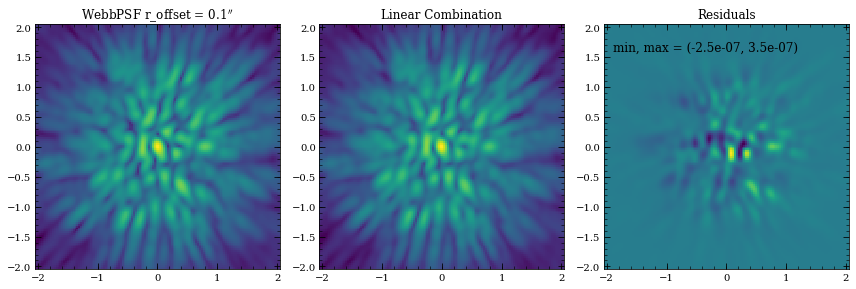

In [195]:
fig, ax = plt.subplots(1,3, figsize=(12,5))

i = 1

psf = psf_over_list[i]
ydata = nrc_utils.pad_or_cut_to_size(psf, psf_off_over.shape)
ymod = f(xdata, avals[i], bvals[i])
diff = ydata - ymod
print(np.abs(diff).max())

extent = np.array([-1,1,-1,1])*pixscale*ydata.shape[0]/2
ax[0].imshow(ydata**0.2, extent=extent)
ax[0].set_title(r'WebbPSF r_offset = {:.1f}$^{{\prime\prime}}$'.format(shift_asec[i]))
ax[1].imshow(ymod**0.2, extent=extent)
ax[1].set_title('Linear Combination')
ax[2].imshow(diff, extent=extent)
ax[2].set_title('Residuals')
mm_str = r'min, max = ({:.1e}, {:.1e})'.format(diff.min(),diff.max())
ax[2].text(-1.9, 1.6, mm_str, fontsize=12)

fig.tight_layout()
fig.savefig(outdir + 'psf_model.pdf')

In [86]:
res.x

array([ 0.94831125,  0.73049707])

In [ ]:
def func_opt(params, xdata, ydata):
    model = xdata[0] * params[0] + ydata[0] * params[1]
    return ydata - model
res = least_squares(shift_subtract, init_pars, diff_step=0.1,
                    loss='soft_l1', f_scale=1.0, args=(reference,target), 
                    kwargs={'mask':mask,'pad':pad,'shift_function':shift_function})


In [ ]:

def func_opt(params, xdata, ydata):
    model = xdata[0] * params[0] + ydata[0] * params[1]
    return ydata - model
    #return (ydata - numpy.dot(xdata, params))


leastsq(func, x0, args=(xdata, ydata))